In [4]:
import sys
sys.path.insert(0, '..')


In [5]:
from pathlib import Path

import extinction
import numpy as np
import pandas as pd
import sfdmap
import yaml
from astropy import modeling
from matplotlib import pyplot as plt
from scipy.ndimage.filters import median_filter
from scipy.optimize import curve_fit
from scipy.stats import norm
from sndata.sdss import Sako18Spec

from spec_analysis.features import ObservedFeature


In [6]:
feature_alias = {
    'pW1': 'Ca ii H&K',
    'pW2': 'Si ii λ4130',
    'pW3': 'Mg ii, Fe ii',
    'pW4': 'Fe ii, Si ii',
    'pW5': 'S ii λ5449, λ5622',
    'pW6': 'Si ii λ5972',
    'pW7': 'Si ii λ6355',
    'pW8': 'Ca ii IR triplet'}

In [7]:
_project_root = Path('.').resolve().parent
_dust_dir = _project_root / 'spec_analysis' / 'schlegel98_dust_map'
_results_dir = _project_root / 'results'


In [8]:
s18 = Sako18Spec()
s18.download_module_data()

# Load the dustmap used during the analysis
DUST_MAP = sfdmap.SFDMap(_dust_dir)

# Load feature measurements
PIPELINE_DATA = pd.read_csv(_results_dir / 'final_sdss.csv', index_col=['obj_id', 'time'])

# Load feature definitions
with (_project_root / 'app_config.yml').open() as infile:
    FEATURES = yaml.safe_load(infile)['features']


In [9]:
def load_data_for_sdss_id(obj_id, time, rv=3.1, bin_size=10):
    """Load an object's spectrum from the SDSS data release and add columns for 
    intermediate calculations used in our analysis.
    
    Args:
        obj_id (int, str): The Id of the object to load data for
        time      (float): The JD of the observed spectrum
    """
    
    sdss_data = s18.get_data_for_id(str(obj_id))
    sdss_data = sdss_data[sdss_data['time'] == time]
    wave = sdss_data['wavelength']
    flux = sdss_data['flux']

    # Determine extinction
    mwebv = DUST_MAP.ebv(sdss_data.meta['ra'], sdss_data.meta['dec'], frame='fk5j2000', unit='degree')
    mag_ext = extinction.fitzpatrick99(wave, rv * mwebv, rv)

    # Correct flux to rest-frame
    sdss_data['rest_wave'] = wave / (1 + sdss_data.meta['z'])
    sdss_data['rest_flux'] = sdss_data['flux'] * 10 ** (0.4 * mag_ext)
    sdss_data['bin_flux'] = median_filter(sdss_data['rest_flux'], bin_size)
    
    return sdss_data


In [10]:
def get_feature_data(obj_id, time, feat_id):
    """Return measurements for a given feature
    
    Args:
        obj_id (int, str): The Id of the object to load data for
        time      (float): The JD of the observed spectrum
        feat        (str): The id of the feature to load data for
    """

    feature_measurements = PIPELINE_DATA.loc[int(obj_id), time]
    return feature_measurements[feature_measurements['feat_name'] == feat_id].iloc[0]


In [11]:
# The default size of a figure axis
DEFAULT_AXIS_SIZE = (10, 6)


In [38]:
def plot_sdss_spectrum_measurements(obj_id, time, feat_choice, colors, axis=None):
    """Plot a feature's pseudo equivilent width
    
    Args:
        obj_id (int, str): The Id of the object to load data for
        time      (float): The JD of the observed spectrum
        feat_choice (list): The id(s) of the feature(s) to load data for
        axis       (Axis): Optionally use a pre-existing matplotlib axis
    """ 
    
    if axis is None:
        axis = plt.subplots(figsize=DEFAULT_AXIS_SIZE)[1]
    
    sdss_data = load_data_for_sdss_id(obj_id, time)
    rest_wave = sdss_data['rest_wave']
    rest_flux = sdss_data['rest_flux']
    bin_flux = sdss_data['bin_flux']
    
    feat_xs = []
    feat_rest_flux = []
    fitted_feat = []
    
    for feat in feat_choice:
        feat_data = get_feature_data(obj_id, time, feat)
        feat_start = feat_data['feat_start']
        feat_end = feat_data['feat_end']
    
        flux_start = np.interp(feat_start, rest_wave, bin_flux)
        flux_end = np.interp(feat_end, rest_wave, bin_flux)
        
        # Get wavelength and flux values for just the feature
        i = (feat_start <= rest_wave) & (rest_wave <= feat_end)
        x = rest_wave[i]
        y2 = rest_flux[i]
        
        feat_xs.append(x)
        feat_rest_flux.append(y2)
        
        fit_params = np.polyfit([feat_start, feat_end], [flux_start, flux_end], 1)
        fit_func = np.poly1d(fit_params)
        y = fit_func(x)
        
        fitted_feat.append(y)
 
    
    axis.plot(rest_wave, rest_flux, color='#AAAAAA', alpha = 0.9, linewidth=.5)
    axis.set_xlim(3500,6800)
    axis.plot(rest_wave, bin_flux, color='k', linewidth=1, label=f'SN ID {obj_id}')
    
    i=0
    for x, y, y2 in zip(feat_xs, feat_rest_flux, fitted_feat):
        c = colors[i]
        alias = feature_alias[feat_choice[i]]
        axis.fill_between(x, y2, y, color=c, alpha=.3, label=f'{feat_choice[i]} ({alias})')
        axis.plot(x, y2, color='gray', linestyle='--')
        i+=1
    
    #axis.axvline(feat_start, color='k', alpha=.3, linestyle='--')
    #axis.axvline(feat_end, color='k', alpha=.3, linestyle='--')
    
    axis.legend(framealpha=1, loc='upper right')
    axis.set_xlabel(r'Wavelength ($\AA$)')
    axis.set_ylabel('Flux')
    

In [22]:
color_list = ['lightgreen', 'mediumpurple', 'coral', 'yellow', 'royalblue', 'hotpink', 'chocolate']
color_list2 = ['#88CCEE', '#CC6677', '#DDCC77', '#117733', '#332288', '#882255', '#44AA99']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.


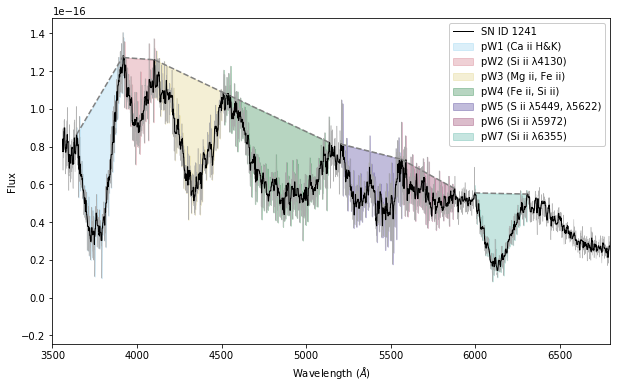

In [39]:
plot_sdss_spectrum_measurements(1241, 2453636.5, ['pW1', 'pW2', 'pW3', 'pW4', 'pW5', 'pW6', 'pW7'], color_list2)
